# WestRock IDMS Exploration

## Environment Setup

In [1]:
import difflib
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sys
sys.path.insert(0, '..')
import warnings
import zlib

# local
from libs.viz.utils import add_vbar_labels, add_hbar_labels

## Settings

In [2]:
plt.style.use('dark_background')
#sns.set_style('darkgrid')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

warnings.filterwarnings('ignore')

wd = os.getcwd()
print(wd)

C:\Users\tom.fiorelli\Documents\GitHub\davos-data-project\notebooks


Read data

In [3]:
inspection_records_df = pd.read_csv(r'../data/raw_data/westrock/Inspection_Records_Report.csv')
master_df = pd.read_csv(r'../data/raw_data/westrock/Master_Database_Report.csv')

In [4]:
inspection_records_df.head()

,#,Next External Inspection,Next Internal Inspection,Next UT Inspection,Date,Equipment Name,Equipment Number,SAP Functional Location Number,Equipment Type,Equipment Area,Risk Rating,Type,Company,Scope
0,1,No Data,Report Pending,2022,1/1/1998,Kamyr Continuous Digester,T510,NaN,Pressure Vessel,Pulp Mill Digesters (WRC),1,Internal,Sullivan and Associates Inc.,NDE Evaluation
1,2,No Data,Report Pending,2022,1/1/2001,Kamyr Continuous Digester,T510,NaN,Pressure Vessel,Pulp Mill Digesters (WRC),1,Internal/UT Thickness,Sullivan and Associates Inc.,NDE Evaluation
2,3,No Data,Report Pending,2022,1/1/2002,Kamyr Continuous Digester,T510,NaN,Pressure Vessel,Pulp Mill Digesters (WRC),1,Internal,Sullivan and Associates Inc.,NDE Evaluation
3,4,No Data,Report Pending,2022,1/1/2004,Kamyr Continuous Digester,T510,NaN,Pressure Vessel,Pulp Mill Digesters (WRC),1,Internal,Sullivan and Associates Inc.,NDE Evaluation
4,5,No Data,Report Pending,2022,1/1/2005,Kamyr Continuous Digester,T510,NaN,Pressure Vessel,Pulp Mill Digesters (WRC),1,Internal,Sullivan and Associates Inc.,NDE Evaluation


In [5]:
inspection_records_df.shape

(1377, 14)

In [6]:
inspection_records_df.nunique()

#                                 1377
Next External Inspection            16
Next Internal Inspection            23
Next UT Inspection                  16
Date                               262
Equipment Name                     797
Equipment Number                   797
SAP Functional Location Number     136
Equipment Type                       4
Equipment Area                      15
Risk Rating                          4
Type                                 8
Company                             21
Scope                               11
dtype: int64

## Who is WestRock using for inspections

In [7]:
set(inspection_records_df['Company'])

{'ATS',
 'Acuren',
 'Alloy Cladding',
 'GEIS',
 'JLM Advanced Technical Svcs. Inc.',
 'Kadant Black Clawson',
 'Longview Inspection',
 'M. C. Macke, LLC',
 'Millennium Metallurgy, Ltd',
 'Millennium/Sullvian & Assocs.',
 'Orbital Engineering Inc.',
 'Southern Iron & Equipment',
 'Stebbins',
 'Structural Preservation Systems LLC',
 'Sullivan and Associates Inc.',
 'TEAM QUALSPEC',
 'The Mill',
 'Thomas Industrial & Mech. Cntrs.',
 'Triosim',
 'WrightSpec',
 'Zuuk International'}

## Breakdown of inspection types

In [9]:
inspection_records_df.groupby(['Type'])['#'].nunique()

Type
External                           61
External/Internal                  55
External/Internal/UT Floor          1
External/Internal/UT Thickness    390
External/UT Thickness             180
Internal                           93
Internal/UT Thickness              26
UT Thickness                       45
Name: #, dtype: int64

## Process dates

In [10]:
inspection_records_df['Date'] = pd.to_datetime(inspection_records_df['Date'])

In [11]:
inspection_records_df['Date'].min()

Timestamp('1998-01-01 00:00:00')

In [12]:
inspection_records_df['Date'].max()

Timestamp('2023-04-21 00:00:00')

In [47]:
inspection_records_df['Year'] = inspection_records_df['Date'].dt.year
inspection_records_df['Month'] = inspection_records_df['Date'].dt.month

## Any difference in inspection types in 2023 ?

In [14]:
inspection_records_df[inspection_records_df['Year']==2023].groupby(['Type'])['#'].nunique()

Type
External                           5
External/Internal                 13
External/Internal/UT Thickness    48
External/UT Thickness             13
Internal                          29
UT Thickness                       1
Name: #, dtype: int64

## Inspections over time

In [15]:
inspection_records_df.groupby(['Year'])['#'].nunique()

Year
1998      1
1999      1
2001      4
2002      6
2003      2
2004      8
2005      3
2006      5
2007      3
2008      5
2009      6
2010      3
2011      3
2012      6
2013     10
2014     22
2015    140
2016     73
2017    131
2018    238
2019    121
2020     65
2021    274
2022    138
2023    109
Name: #, dtype: int64

<AxesSubplot: xlabel='Year'>

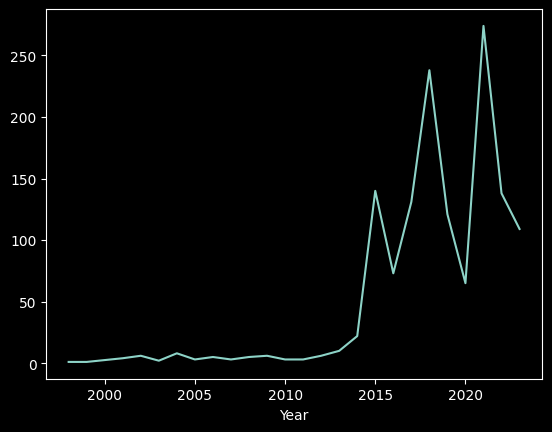

In [16]:
inspection_records_df.groupby(['Year'])['#'].nunique().plot()

### There seems to be a noticeable change in inspection frequency in 2015, followed by some kind of cycle

<AxesSubplot: xlabel='Year,Month'>

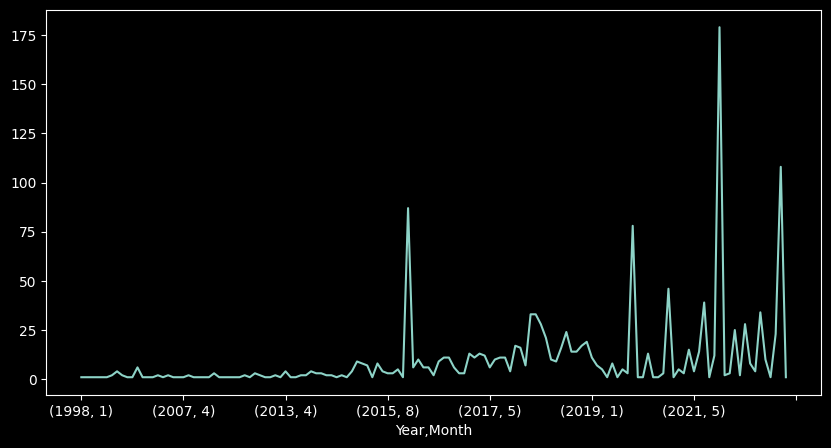

In [48]:
inspection_records_df.groupby(['Year', 'Month'])['#'].nunique().plot()

<AxesSubplot: xlabel='Month'>

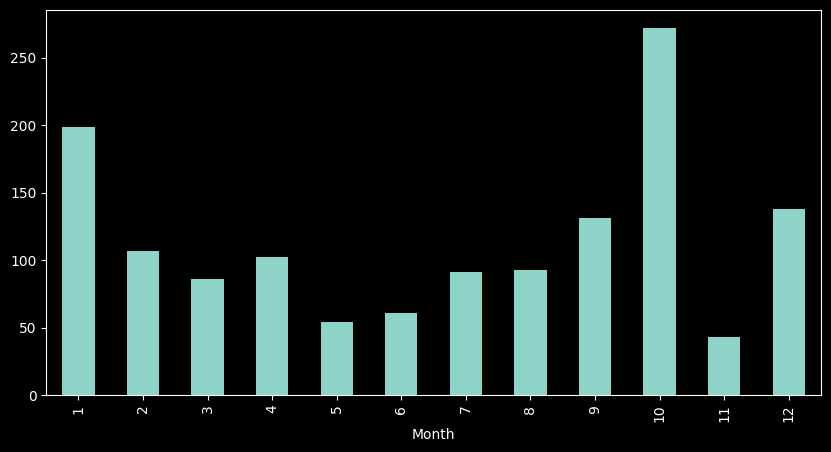

In [50]:
inspection_records_df.groupby(['Month'])['#'].nunique().plot.bar()

<AxesSubplot: xlabel='Month'>

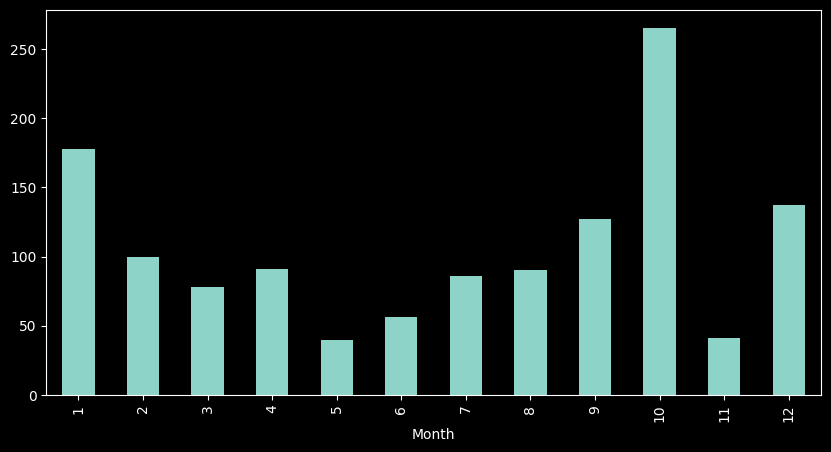

In [51]:
inspection_records_df[inspection_records_df['Year']>=2015].groupby(['Month'])['#'].nunique().plot.bar()

<AxesSubplot: xlabel='Month'>

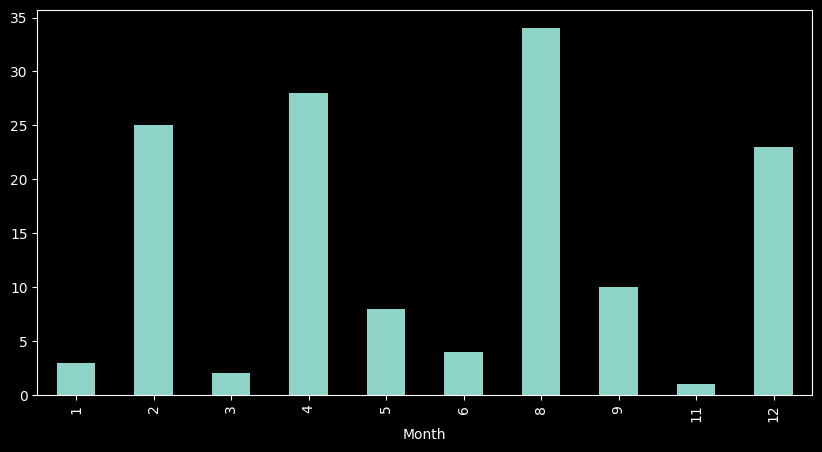

In [52]:
inspection_records_df[inspection_records_df['Year']==2022].groupby(['Month'])['#'].nunique().plot.bar()

In [17]:
inspection_records_df[inspection_records_df['Year']==2023].groupby(['Equipment Type', 'Equipment Area'])['#'].nunique().to_frame().reset_index().sort_values(by='#', ascending=False)

,Equipment Type,Equipment Area,#
1,Pressure Vessel,No. 1 Paper Machine (WRC),23
3,Pressure Vessel,Recovery Boilers (WRC),21
7,Storage Tank,No. 1 Paper Machine (WRC),15
2,Pressure Vessel,Pulp Mill Digesters (WRC),13
5,Storage Tank,Chemical Production (WRC),9
8,Storage Tank,No. 2 Paper Machine (WRC),9
4,Pressure Vessel,Utilities (WRC),3
6,Storage Tank,CoGen (WRC),2
9,Storage Tank,No. 3 Paper Machine (WRC),2
11,Storage Tank,Pulp Mill Digesters (WRC),2


In [18]:
inspection_bytypeyear_df = inspection_records_df.groupby(['Year', 'Equipment Type'])['#'].nunique().to_frame().reset_index()

<AxesSubplot: xlabel='Year'>

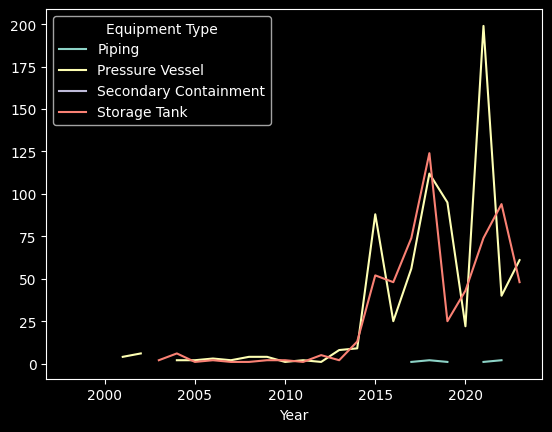

In [19]:
inspection_bytypeyear_df.pivot(index='Year', columns='Equipment Type', values='#').plot()

In [45]:
inspection_bytype_df = inspection_records_df.groupby(['Equipment Type'])['#'].nunique().to_frame().reset_index().sort_values(by=['#'], ascending=False)

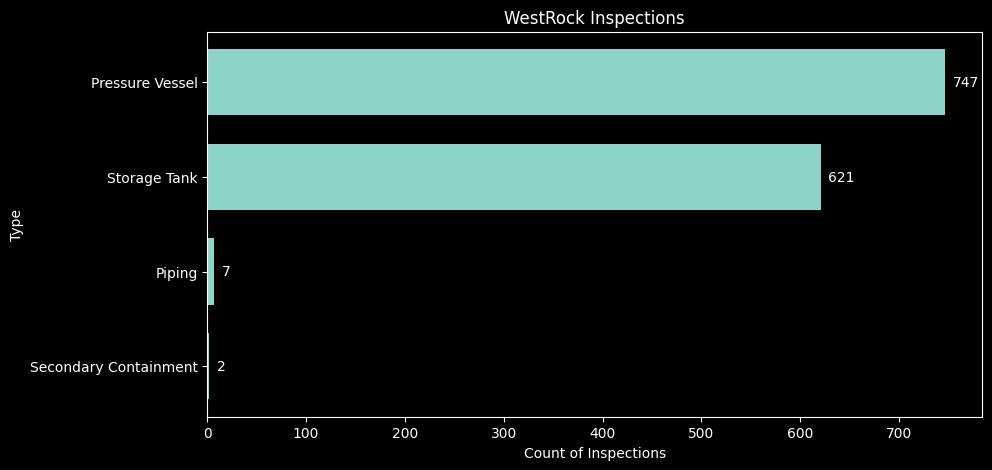

In [46]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)

x = inspection_bytype_df["Equipment Type"]
y = inspection_bytype_df["#"]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Inspections')
ax.set_title('WestRock Inspections')
ax.set_ylabel('Type')
ax.set_xlabel('Count of Inspections')

add_hbar_labels(x, y)

#ax.set_xticks(x)
#ax.set_xticklabels(component_df["Cause Description"])
#ax.legend()

ax.invert_yaxis()

#fig.tight_layout()

#plt.xticks(rotation=90)
plt.show()

In [20]:
inspection_byareayear_df = inspection_records_df.groupby(['Year', 'Equipment Area'])['#'].nunique().to_frame().reset_index()

<AxesSubplot: xlabel='Year'>

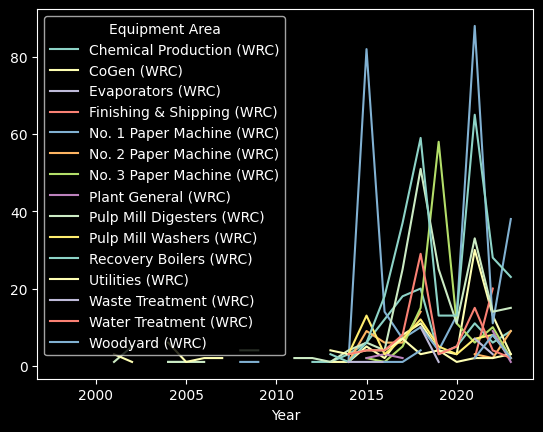

In [21]:
inspection_byareayear_df.pivot(index='Year', columns='Equipment Area', values='#').plot()

In [42]:
inspection_byarea_df = inspection_records_df.groupby(['Equipment Area'])['#'].nunique().to_frame().reset_index().sort_values(by=['#'], ascending=False)

In [43]:
inspection_byarea_df.head()

,Equipment Area,#
4,No. 1 Paper Machine (WRC),270
10,Recovery Boilers (WRC),267
8,Pulp Mill Digesters (WRC),211
6,No. 3 Paper Machine (WRC),110
0,Chemical Production (WRC),100


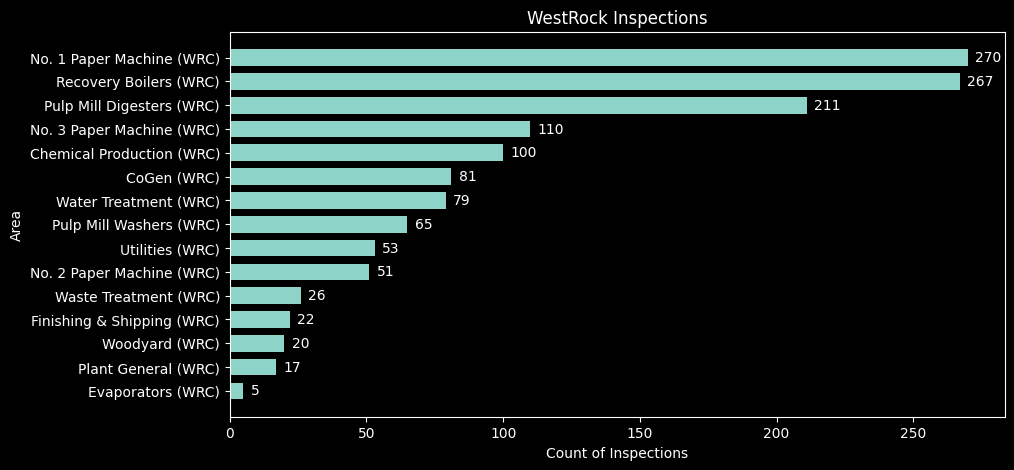

In [44]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)

x = inspection_byarea_df["Equipment Area"]
y = inspection_byarea_df["#"]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Inspections')
ax.set_title('WestRock Inspections')
ax.set_ylabel('Area')
ax.set_xlabel('Count of Inspections')

add_hbar_labels(x, y)

#ax.set_xticks(x)
#ax.set_xticklabels(component_df["Cause Description"])
#ax.legend()

ax.invert_yaxis()

#fig.tight_layout()

#plt.xticks(rotation=90)
plt.show()

In [22]:
inspection_records_df.groupby(['Equipment Type', 'Equipment Area'])['#'].nunique().to_frame().reset_index().sort_values(by='#', ascending=False)

,Equipment Type,Equipment Area,#
11,Pressure Vessel,Recovery Boilers (WRC),196
5,Pressure Vessel,No. 1 Paper Machine (WRC),187
9,Pressure Vessel,Pulp Mill Digesters (WRC),169
16,Storage Tank,Chemical Production (WRC),88
20,Storage Tank,No. 1 Paper Machine (WRC),83
26,Storage Tank,Recovery Boilers (WRC),71
7,Pressure Vessel,No. 3 Paper Machine (WRC),63
29,Storage Tank,Water Treatment (WRC),59
25,Storage Tank,Pulp Mill Washers (WRC),57
22,Storage Tank,No. 3 Paper Machine (WRC),47


## Filtering for the inspection we are interested in

In [53]:
filtered_inspections_df = inspection_records_df[
    
    (inspection_records_df['Year']>=2015) & 
    inspection_records_df['Equipment Type'].isin(['Storage Tank', 'Pressure Vessel'])

]

In [54]:
filtered_inspections_df.shape

(1280, 16)

In [55]:
filtered_inspection_byarea_df = filtered_inspections_df.groupby(['Equipment Area'])['#'].nunique().to_frame().reset_index().sort_values(by=['#'], ascending=False)

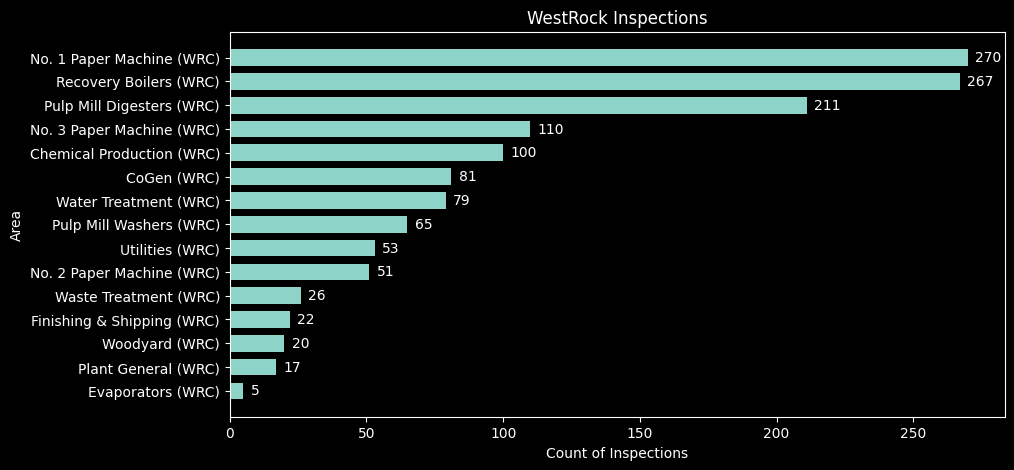

In [56]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)

x = inspection_byarea_df["Equipment Area"]
y = inspection_byarea_df["#"]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Inspections')
ax.set_title('WestRock Inspections')
ax.set_ylabel('Area')
ax.set_xlabel('Count of Inspections')

add_hbar_labels(x, y)

#ax.set_xticks(x)
#ax.set_xticklabels(component_df["Cause Description"])
#ax.legend()

ax.invert_yaxis()

#fig.tight_layout()

#plt.xticks(rotation=90)
plt.show()

In [70]:
top_contractors = filtered_inspections_df.groupby(['Company'])['#'].nunique().to_frame().reset_index().sort_values(by=['#'], ascending=False)

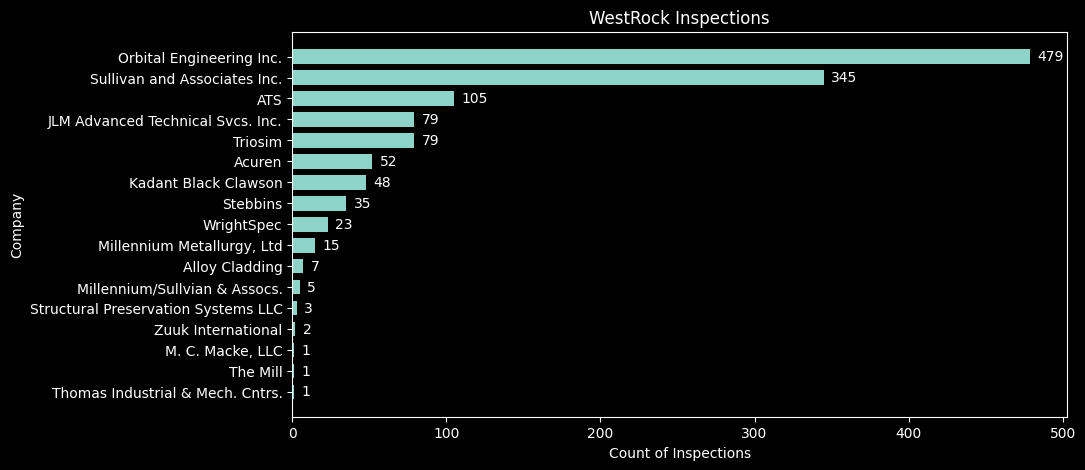

In [71]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)

x = top_contractors["Company"]
y = top_contractors["#"]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Inspections')
ax.set_title('WestRock Inspections')
ax.set_ylabel('Company')
ax.set_xlabel('Count of Inspections')

add_hbar_labels(x, y)

#ax.set_xticks(x)
#ax.set_xticklabels(component_df["Cause Description"])
#ax.legend()

ax.invert_yaxis()

#fig.tight_layout()

#plt.xticks(rotation=90)
plt.show()

In [23]:
master_df.head()

,#,Next External Inspection,Next Internal Inspection,Next UT Inspection,Equipment Name,Equipment Number,SAP Number / Alternate Number,Location / Mill No.,Area,Equipment Type,Risk
0,1,Review Pending,Review Pending,Review Pending,PM1 Dryer No. 01,4530-PM1-DRY1-DN01,1DRY1-DRYERS-DN01,1st Dryer Section,No. 1 Paper Machine (WRC) ...,Pressure Vessel,1
1,2,Review Pending,Review Pending,Review Pending,PM1 Dryer No. 02,4530-PM1-DRY1-DN02,1DRY1-DRYERS-DN02,1st Dryer Section,No. 1 Paper Machine (WRC) ...,Pressure Vessel,1
2,3,Review Pending,2026,Review Pending,PM1 Dryer No. 03,4530-PM1-DRY1-DN03,1DRY1-DRYERS-DN03,1st Dryer Section,No. 1 Paper Machine (WRC) ...,Pressure Vessel,1
3,4,Review Pending,Review Pending,Review Pending,PM1 Dryer No. 04,4530-PM1-DRY1-DN04,1DRY1-DRYERS-DN04,1st Dryer Section,No. 1 Paper Machine (WRC) ...,Pressure Vessel,1
4,5,Review Pending,2026,Review Pending,PM1 Dryer No. 05,4530-PM1-DRY1-DN05,1DRY1-DRYERS-DN05,1st Dryer Section,No. 1 Paper Machine (WRC) ...,Pressure Vessel,1


In [24]:
master_df.shape

(1217, 11)

In [25]:
master_df.nunique()

#                                1217
Next External Inspection           17
Next Internal Inspection           24
Next UT Inspection                 17
Equipment Name                   1212
Equipment Number                 1217
SAP Number / Alternate Number     189
Location / Mill No.               508
Area                               16
Equipment Type                      4
Risk                                4
dtype: int64

In [26]:
set(master_df['Equipment Type'])

{'Piping', 'Pressure Vessel', 'Secondary Containment', 'Storage Tank'}

In [27]:
master_df.groupby(['Equipment Type'])['Equipment Number'].nunique().to_frame().reset_index()

,Equipment Type,Equipment Number
0,Piping,1
1,Pressure Vessel,638
2,Secondary Containment,61
3,Storage Tank,517


In [28]:
master_df.groupby(['Equipment Type'])['Risk'].median().to_frame().reset_index()

,Equipment Type,Risk
0,Piping,0.0
1,Pressure Vessel,2.0
2,Secondary Containment,0.0
3,Storage Tank,1.0


In [29]:
master_df.groupby(['Equipment Type'])['Risk'].mean().to_frame().reset_index()

,Equipment Type,Risk
0,Piping,0.000000
1,Pressure Vessel,1.589342
2,Secondary Containment,0.000000
3,Storage Tank,1.187621


In [30]:
master_df['Risk'].max()

3

In [31]:
master_df['Risk'].min()

0

In [32]:
master_df['Risk'].describe()

count    1217.000000
mean        1.337716
std         0.974257
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: Risk, dtype: float64

In [33]:
master_df[master_df['Risk']>2].shape

(148, 11)

In [34]:
master_df[master_df['Risk']>2].groupby(['Equipment Type'])['#'].nunique().to_frame()

,#
Equipment Type,
Pressure Vessel,144
Storage Tank,4


In [35]:
master_df[master_df['Risk']>1].groupby(['Equipment Type'])['#'].nunique().to_frame()

,#
Equipment Type,
Pressure Vessel,346
Storage Tank,210


In [57]:
filtered_master_df = master_df[
    
    master_df['Equipment Type'].isin(['Storage Tank', 'Pressure Vessel'])

]

In [58]:
filtered_master_df['Risk'].describe()

count    1155.000000
mean        1.409524
std         0.948087
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: Risk, dtype: float64

In [62]:
risk_breakdown = filtered_master_df.groupby(['Equipment Type', 'Risk'])['#'].nunique().to_frame().reset_index()

In [64]:
risk_breakdown['Label'] = risk_breakdown['Equipment Type'].astype(str) + '-' + risk_breakdown['Risk'].astype(str)

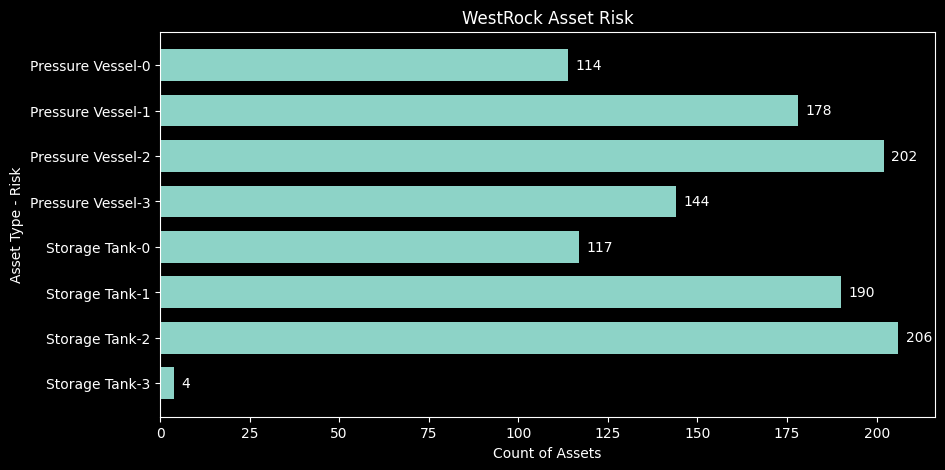

In [67]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (10,5)

x = risk_breakdown["Label"]
y = risk_breakdown["#"]
width =0.7

rects1 = ax.barh(x, y, width, label = 'Inspections')
ax.set_title('WestRock Asset Risk')
ax.set_ylabel('Asset Type - Risk')
ax.set_xlabel('Count of Assets')

add_hbar_labels(x, y)

#ax.set_xticks(x)
#ax.set_xticklabels(component_df["Cause Description"])
#ax.legend()

ax.invert_yaxis()

#fig.tight_layout()

#plt.xticks(rotation=90)
plt.show()